In [23]:
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [24]:
file_list = [file.replace('../Data/Artist/test_top100/', '') for file in glob.glob('../Data/Artist/test_top100/*.jpg')]
fileCount = len(file_list)
fileCount

10

In [25]:
def imageGenerate(src, max_height, angle):
    
    max_width = np.uint(max_height * 1.5)

    height, width = src.shape[0:2]
    ratio = height / max_height
    
    # 입력 이미지의 높이가 설정한 이미지의 최대 높이보다 크면 리사이즈 수행
    if height > max_height :
        resize_height = max_height
        resize_width = np.uint(width // ratio)
        img = cv2.resize(src, (resize_width, resize_height), cv2.INTER_AREA) # 폭이 길면 중심기준으로 좌우 잘림
        dy = 0
    
    # 입력 이미지의 높이가 설정한 이미지의 최대 높이보다 작으면 리사이즈 수행하지 않음
    else : 
        resize_height = height
        resize_width = width
        dy = (max_height - resize_height) // 2

    dx = (max_width - resize_width) // 2
    mtrx = np.float32([[1,0,dx],[0,1,dy]])

    # 입력 이미지를 규격 프레임의 중심에 넣는다
    img = cv2.warpAffine(img, mtrx, (max_width, max_height))

    # 이미지 회전
    mtrx_rot = cv2.getRotationMatrix2D((max_width/2, max_height/2), angle, 0.9)
    return cv2.warpAffine(img, mtrx_rot, (max_width,max_height))  

In [28]:
angles = (np.arange(-15, 15, 0.5))
angles

array([-15. , -14.5, -14. , -13.5, -13. , -12.5, -12. , -11.5, -11. ,
       -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,  -6.5,
        -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,  -2. ,
        -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,   2.5,
         3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,   7. ,
         7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,  11. ,  11.5,
        12. ,  12.5,  13. ,  13.5,  14. ,  14.5])

In [32]:
read_path = '../Data/Artist/test_top100/'
save_path = '../Data/Artist/train_rot/'

max_height = 400
target_count = 0
for file in file_list:
    try :
        file_path = read_path + file
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)
        height, width = img.shape[:2]

        id = 0

        if height * 1.5 > width :
            for angle in angles:
                file_name = file.replace('../Data/Artist/test_top100/', '').replace('.jpg', '') + '_%02d'%id + '.jpg'
                cv2.imwrite(save_path + file_name, imageGenerate(img, 400, angle))
                id += 1
            
    except :
        pass


---
## 학습데이터 읽기

In [39]:
fileList = [file for file in glob.glob('../Data/Artist/train_rot/*.jpg')]
fileCount = len(fileList)
fileCount

480

In [36]:
height = 400
width = 600
colors = 3

trainData = np.zeros(fileCount * height * width * colors).reshape(-1, height, width, colors)

In [37]:
i = 0
for file in sorted(glob.glob('../Data/Artist/train_rot/*.jpg')):
    img = np.array(Image.open(file), dtype=np.int32)
    trainData[i] = img
    i += 1

In [48]:
# 타겟의 작품명을 이용하여 DB 연동필요
targetData = []
for i in range(8):
    targetData = np.concatenate([targetData, np.full(60, i)])

targetData

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3.

In [49]:
train = trainData.reshape(-1, height, width, colors) / 255.0

In [50]:
trainData, testData, trainTarget, testTarget = train_test_split(
    train, targetData, test_size=0.2, random_state=42
)

trainData, valData, trainTarget, valTarget = train_test_split(
    trainData, trainTarget, test_size=0.2, random_state=42
)

In [51]:
print(trainData.shape)
print(trainTarget.shape)
print(valData.shape)
print(valTarget.shape)
print(testData.shape)
print(testTarget.shape)

(307, 400, 600, 3)
(307,)
(77, 400, 600, 3)
(77,)
(96, 400, 600, 3)
(96,)


---

In [52]:
model = keras.Sequential()

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-08-04 18:32:47.679425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-04 18:32:47.679608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [53]:
model.add(
    keras.layers.Conv2D(
        64, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
        input_shape = (height, width, colors) 
    )
)

In [54]:
model.add(keras.layers.MaxPooling2D(2))

In [55]:
model.add(
    keras.layers.Conv2D(
        64, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [56]:
model.add(keras.layers.MaxPooling2D(2))

In [57]:
model.add(
    keras.layers.Conv2D(
        128, 
        kernel_size = 3, 
        activation = 'relu',
        padding = 'same',
    )
)

In [58]:
model.add(keras.layers.MaxPooling2D(2))

In [59]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.5))  # 50% Drop Out
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dropout(0.5))  # 50% Drop Out
model.add(keras.layers.Dense(8, activation='softmax'))

In [60]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 600, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 300, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 300, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 150, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 75, 128)      0

In [61]:
# 모델 학습하기
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics ='accuracy'
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("../Data/Artist/model/top13.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    trainData, 
    trainTarget, 
    epochs=50, 
    validation_data=[valData, valTarget],
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/50


2022-08-04 18:33:05.462506: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-04 18:33:05.801735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 2.4688 - accuracy: 0.3192

2022-08-04 18:33:20.491063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 17s 2s/step - loss: 2.4688 - accuracy: 0.3192 - val_loss: 0.8235 - val_accuracy: 0.9870
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: 0.4913 - accuracy: 0.8371 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 3/50
10/10 [==============================] - 14s 1s/step - loss: 0.1016 - accuracy: 0.9674 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 4/50
10/10 [==============================] - 14s 1s/step - loss: 0.0451 - accuracy: 0.9805 - val_loss: 2.3620e-05 - val_accuracy: 1.0000
Epoch 5/50
10/10 [==============================] - 14s 1s/step - loss: 0.0184 - accuracy: 0.9935 - val_loss: 2.1591e-05 - val_accuracy: 1.0000
Epoch 6/50
10/10 [==============================] - 14s 1s/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 1.6183e-06 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 14s 1s/step - loss: 0.0047 - accuracy: 0.9967 - val_loss: 0.0640 - val_accuracy: 0.9870
Epoch 8/50
10/10 [=

In [62]:
model.evaluate(testData, testTarget)

3/3 [==============================] - 1s 356ms/step - loss: 1.9237e-06 - accuracy: 1.0000


[1.9237199921917636e-06, 1.0]

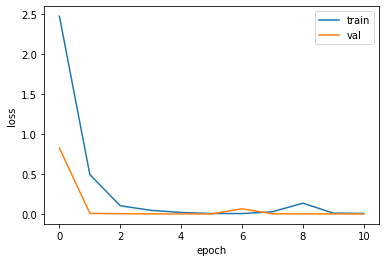

In [63]:
# 시각화 해보기
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()